# Bike Sharing Demand 

**
주어진 feature 기반으로 특정시점의 자전거 대여 수요를 예측하는 regression 문제임.  
Tensorflow(1.4+)로 학습을 통해 예측 모델을 만드는 방법은 네 가지 정도로 볼 수 있음.
**

1.가설함수(hypothesis), 손실함수(loss), 가중치(W), 바이어스(b) 등을 정의하고 neural network 를 직접 구현하는 방법
2.tensorflow.layers 같은 High level API 를 사용하여 neural network 를 구현하는 방법  
3.tensorflow.estimators 같은 High level API를 사용하여 neural network 를 구현하는 방법  
4.tensorflow.keras or Keras 같은 High level API를 사용하여 neural network 를 구현하는 방법  

여기서는 세번째, tensorflow.estimator.DNNRegressor API를 사용하여 multi-layer neural network 를 구현한다. 
별로 안 좋은 예인것 같음 (디테일하게 컨트롤 할 수 있으려면 Custom estimator 를 만들어야 할 듯..)  
tensorflow row level, layers, keras 를 사용하는 패턴과 너무 상이함.

확인 할 내용

- 입력 feature 들에 대한 전처리, 사용할 feature 선택에 따른 차이.
- 가중치 초기화를 random 으로 했을 경우, Xavier/He initializer 를 사용했을 경우 차이.
- 활성화 함수(sigmoid/tanh/relu) 사용에 따른 차이.
- Layer 수, Layer 별 neuron 수에 따른 차이.
- Optimizer 사용에 따른 차이 (GradientDescent, Adam 등)

https://www.kaggle.com/c/bike-sharing-demand

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Dataset

In [2]:
# parse_dates : 'datetime' 컬럼을 python date type 으로 처리하기 위해
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])

print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Explore

In [3]:
# 차트를 jupyter notebook에 출력해서 보기 위한 명령어
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

### Explore datetime

In [4]:
# datatime 을 python date type 으로 load 했기 때문에 '.dt' 속성을 이용해서 년/월/일/시/분/초/요일 등의 정보에 접근 가능함
# datatime 으로 부터 년/월/일/시/분/초 컬럼 추가
train["datetime-year"] = train["datetime"].dt.year
train["datetime-month"] = train["datetime"].dt.month
train["datetime-day"] = train["datetime"].dt.day
train["datetime-hour"] = train["datetime"].dt.hour
train["datetime-minute"] = train["datetime"].dt.minute
train["datetime-second"] = train["datetime"].dt.second

print(train.shape)
train[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute", "datetime-second"]].head()

(10886, 18)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


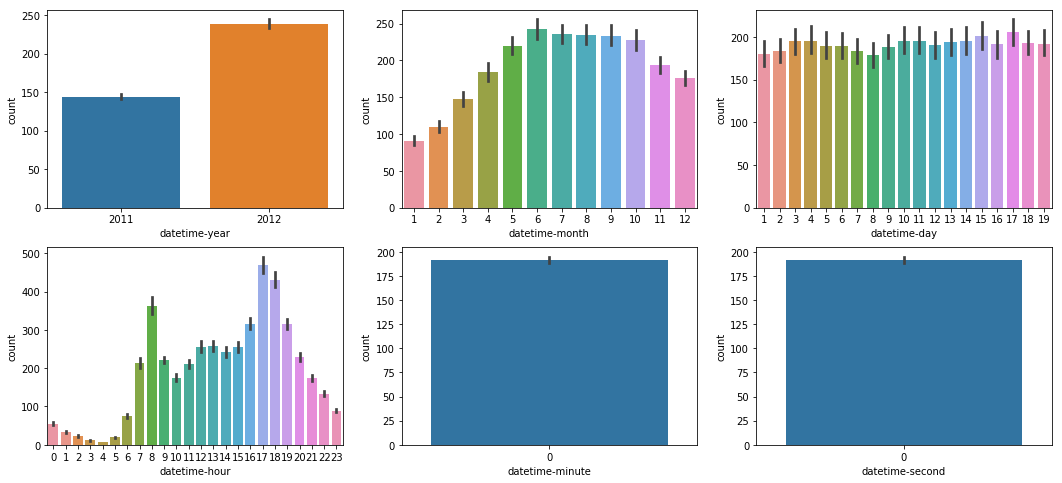

In [5]:
# 2 X 3 subplot 선언
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
# subplot size 선언
figure.set_size_inches(18, 8)
# time 관련 feature 들과 대여 수(count) 관계를 barplot 을 이용해 확인
sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)
sns.barplot(data=train, x="datetime-day", y="count", ax=ax3)
sns.barplot(data=train, x="datetime-hour", y="count", ax=ax4)
sns.barplot(data=train, x="datetime-minute", y="count", ax=ax5)
sns.barplot(data=train, x="datetime-second", y="count", ax=ax6)

** Lesson Learned **
  * **datetime-minute**와 **datetime-second**는 현재 기록되고 있지 않다. 그러므로 사용할 필요가 없다.
  * train.csv와 test.csv는 **datetime-day**를 기준으로 나뉘어져 있다. 그러므로 **datetime-day**를 feature로 사용해서는 안 된다.

### Explore hour - workingday

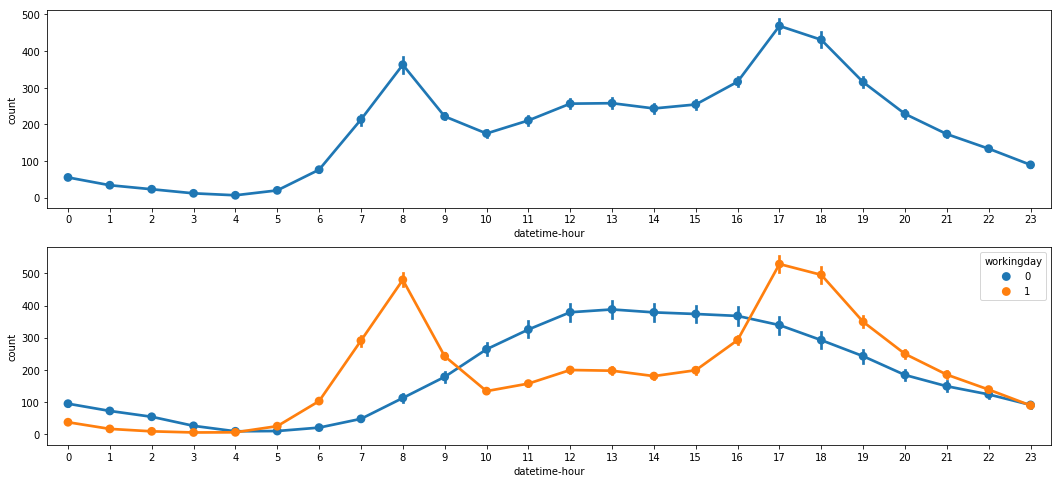

In [6]:
# 2 X 1 subplot 선언
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

# 시간과 대여 수(count)의 관계를 pointplot 을 이용해 확인
sns.pointplot(data=train, x="datetime-hour", y="count", ax=ax1)
# hue="workingday" 를 추가해서 주중 시간대와, 주말 시간대별 대여수 관계를 확인
sns.pointplot(data=train, x="datetime-hour", y="count", hue="workingday", ax=ax2)

** Lesson Learned **
  * 주중(workingday==1)에는 출근 시간과 퇴근 시간에 자전거를 많이 대여한다.
  * 주말(workingday==0)에는 오후 시간에 자전거를 많이 대여한다.
  * 주중(월,화,수,목,금)이 주말(토,일)보다 많기 때문에, 두 개를 나눠서 보지 않으면 주말의 특성을 파악할 수 없다.

### Explore hour - dayofweek

In [7]:
# 요일(dayofweek) 컬럼 추가 (0 = monday, ~ 6 = sunday) 
train["datetime-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "datetime-dayofweek"]].head()

(10886, 19)


,datetime,datetime-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


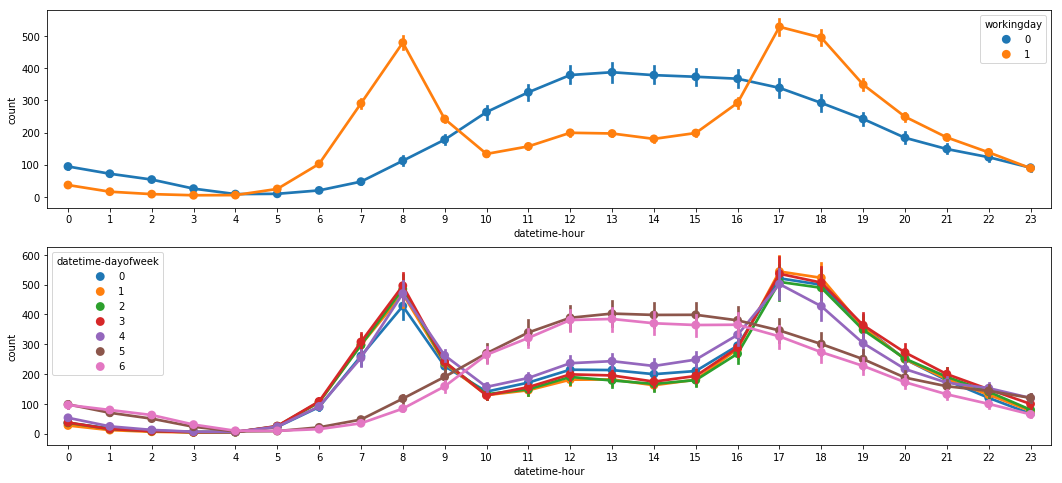

In [8]:
# 2 X 1 subplot 선언
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

# 주중/주말 시간대별 대여수 차이
sns.pointplot(data=train, x="datetime-hour", y="count", hue="workingday", ax=ax1)
# 요일 시간대별 대여수 차이
sns.pointplot(data=train, x="datetime-hour", y="count", hue="datetime-dayofweek", ax=ax2)

** Lesson Learned **
  * 금요일(workingday==4)는 주중이지만, 아주 약간 주말의 특성을 반영하고 있다.
  * 비슷하게 월요일(workingday==0)도 아주 약간 주말의 특성을 반영하고 있다.
  * 사람들이 휴가를 월요일과 금요일에 사용하기 때문이라고 추측할 수 있다.

### Concatenate year and month

In [9]:
# datetime 을 받아서 '년-월' 값을 만들어 주는 함수 정의
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)
# 년-월 컬럼 추가 (년-월 별 대여량 차이 확인 하기 위해서)
train["datetime-year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "datetime-year_month"]].head()

(10886, 20)


,datetime,datetime-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


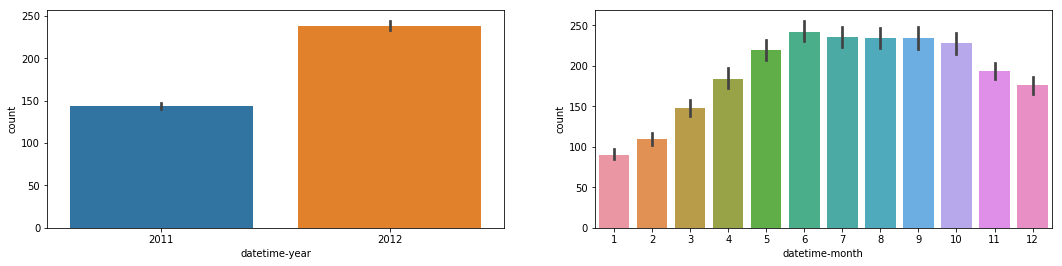

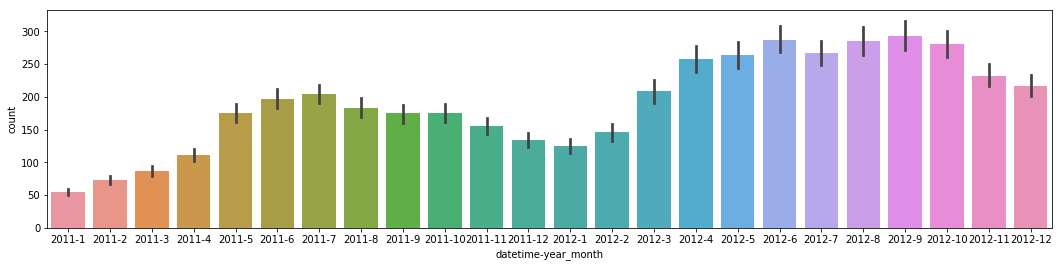

In [10]:
# 1 X 1 subplot 선언
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)
# 연도별 대여수 차이 확인
sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
# 월별 대여수 차이 확인
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)

# 하나짜리 subplot 선언 (차트 하나를 원하는 사이즈로 출력하고 싶을 때 사용하는 Tip)
figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
# 위에서 새로 추가한 년-월 별 대여수 차이 확인
sns.barplot(data=train, x="datetime-year_month", y="count", ax=ax3)

** Lesson Learned **
  * 2011년 12월과 2012년 1월의 자전거 대여량을 비슷하지만, 두 개를 따로 놓고 보면 이를 알 수 없다.
  * 2011년에는 8월부터 대여량이 감소하고, 2012년에는 7월부터 대여량이 감소한다. 마찬가지로 따로 놓고 보면 이를 알 수 없다.

## Reload Dataset

In [11]:
# 전처리 하기위해 train 원본 데이터를 다시 load
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])

print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [12]:
# test 데이터도 전처리를 같이 해야 하기 때문에 함께 load
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])

print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Preprocessing

### Parse datetime

In [13]:
# train 데이터에 년/월/일/시간/요일 컬럼 추가
train["datetime-year"] = train["datetime"].dt.year
train["datetime-month"] = train["datetime"].dt.month
train["datetime-day"] = train["datetime"].dt.day
train["datetime-hour"] = train["datetime"].dt.hour
train["datetime-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-dayofweek"]].head()

(10886, 17)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


In [14]:
# test 데이터에 년/월/일/시간/요일 컬럼 추가
test["datetime-year"] = test["datetime"].dt.year
test["datetime-month"] = test["datetime"].dt.month
test["datetime-day"] = test["datetime"].dt.day
test["datetime-hour"] = test["datetime"].dt.hour
test["datetime-dayofweek"] = test["datetime"].dt.dayofweek

print(test.shape)
test[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-dayofweek"]].head()

(6493, 14)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,3
1,2011-01-20 01:00:00,2011,1,20,1,3
2,2011-01-20 02:00:00,2011,1,20,2,3
3,2011-01-20 03:00:00,2011,1,20,3,3
4,2011-01-20 04:00:00,2011,1,20,4,3


### Data for train

### Select features for Training

**
<span style="color:red">
One-hot encoding 하기전에는 아무리 해도 좋은 결과가 안나옴 (loss 수렴이 잘 안됨)  
One-hot encoding 을 통해 feature를 늘린 후 성능이 크게 개선 됨
</span>
**

In [15]:
# DataFrame.get_dummies() 를 사용해서 한번에 one-hot encoding 하기 위해 
# neumeric type을 string type 으로 수정
train['season'] = train['season'].astype(str)
train['weather'] = train['weather'].astype(str)
train['datetime-dayofweek'] = train['datetime-dayofweek'].astype(str)
train['datetime-hour'] = train['datetime-hour'].astype(str)

In [16]:
# DataFrame.get_dummies() 를 사용해서 한번에 one-hot encoding 하기 위해 
# neumeric type을 string type 으로 수정
test['season'] = test['season'].astype(str)
test['weather'] = test['weather'].astype(str)
test['datetime-dayofweek'] = test['datetime-dayofweek'].astype(str)
test['datetime-hour'] = test['datetime-hour'].astype(str)

In [17]:
#train 시킬 feature 선언
feature_names = ["season", "holiday", "workingday", "weather",
                 "atemp", "humidity", "datetime-year", 
                 "datetime-hour", "datetime-dayofweek"]

In [18]:
# train 시킬 데이터셋(feature) 준비 : X
# One-hot encoding (neumeric type 이 아닌 컬럼들은 모두 encoding 됨)
X = pd.get_dummies(train[feature_names])

print(X.shape)
X.head()

(10886, 44)


,holiday,workingday,atemp,humidity,datetime-year,season_1,season_2,season_3,season_4,weather_1,...,datetime-hour_7,datetime-hour_8,datetime-hour_9,datetime-dayofweek_0,datetime-dayofweek_1,datetime-dayofweek_2,datetime-dayofweek_3,datetime-dayofweek_4,datetime-dayofweek_5,datetime-dayofweek_6
0,0,0,14.395,81,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,13.635,80,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,13.635,80,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,14.395,75,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,14.395,75,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [19]:
label_name = "count"
# loss 를 RMSLE (Root Mean Square Log Error) 로 측정하기 위해 
# label (actual value) 값을 변환
y = np.log(train[label_name]+1)

y.head(5)

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

### Splitting train, test(evaluate) data set

In [25]:
# train 데이터 검증을 위한 test 데이터 준비
# train 데이터에서 일부 검증용으로 test 셋 분리
# 데이터 건수가 많지 않기 때문에 test 셋을 줄이고 train 셋을 늘리는 것이 좋을것 같음
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(8708, 44) (2178, 44) (8708,) (2178,)


### Kaggle submit data set

In [33]:
# 예측(predict) 할 test 데이터셋 준비 : X_test
X_submit_df = pd.get_dummies(test[feature_names])

print(X_submit_df.shape)
X_submit_df.head()

(6493, 44)


,holiday,workingday,atemp,humidity,datetime-year,season_1,season_2,season_3,season_4,weather_1,...,datetime-hour_7,datetime-hour_8,datetime-hour_9,datetime-dayofweek_0,datetime-dayofweek_1,datetime-dayofweek_2,datetime-dayofweek_3,datetime-dayofweek_4,datetime-dayofweek_5,datetime-dayofweek_6
0,0,1,11.365,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,13.635,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,13.635,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,12.880,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,1,12.880,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### feature standardization  

In [34]:
from sklearn.preprocessing import StandardScaler
# StandardScaler를 이용해 standardization 결과 numpy array 값으로 변경
X_train = StandardScaler().fit_transform(X_train_df)
# DataFrame 을 numpy array 로
y_train = np.float32(y_train_df.values)

X_test = StandardScaler().fit_transform(X_test_df)
y_test = y_test_df.values

X_submit = StandardScaler().fit_transform(X_submit_df)

### Instantiating Features

- numeric_column: It defines that the feature will be a float32 number.
- bucketized_column: It defines a feature that will be bucketized. You can define the range of the buckets.
- categorical_column_with_vocabulary_list: As the name says, it basically does a one-hot-encoding for the column using a vocabulary list.
- categorical_column_with_hash_bucket: Similarly, this definition encodes the categorical values using a hash bucket. You define the number of hashes it will have. This is very useful when you don't know the vocabulary but may cause hash collisions.

In [35]:
n_features = X_train.shape[1]
feature_columns = [tf.feature_column.numeric_column("x", shape=[n_features,1])]

## Train (tensorflow estimator)

### Common constant

In [30]:
# learning rate
learning_rate = 0.001
# epoches 
EPOCHS = 100
# batch size (여기서는 전체 데이터를 분할하지 않고 한번에 사용)
BATCH_SIZE = int(len(train)/1)

### Estimator (model)

In [36]:
# optimizer 
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate
                                ,l1_regularization_strength=0.001)

# estimator
estimator = tf.estimator.DNNRegressor(
                    feature_columns=feature_columns,
                    hidden_units=[1024, 512, 256, 128],
                    optimizer=optimizer,
                    activation_fn=tf.nn.relu,
                    model_dir='model/dnn')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/dnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000246211B7F60>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Input function

In [55]:
# train input function
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": X_train},
      y=np.array(y_train.reshape((len(y_train),1))),
      num_epochs=None, #For training it can use how many epochs is necessary
      shuffle=True
)

evaluate_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": X_test},
      y=y_test,
      num_epochs=1,
      shuffle=False
)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": X_submit},
      y=None,
      num_epochs=1,
      shuffle=False
)

## Train

In [56]:
estimator.train(input_fn=train_input_fn, steps=None, max_steps=30000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into model/dnn\model.ckpt.
INFO:tensorflow:loss = 2775.66, step = 1
INFO:tensorflow:global_step/sec: 74.4281
INFO:tensorflow:loss = 20.1825, step = 101 (1.345 sec)
INFO:tensorflow:global_step/sec: 79.7125
INFO:tensorflow:loss = 9.09111, step = 201 (1.254 sec)
INFO:tensorflow:global_step/sec: 82.1707
INFO:tensorflow:loss = 9.44524, step = 301 (1.217 sec)
INFO:tensorflow:global_step/sec: 81.1694
INFO:tensorflow:loss = 12.2775, step = 401 (1.234 sec)
INFO:tensorflow:global_step/sec: 80.4182
INFO:tensorflow:loss = 10.5316, step = 501 (1.242 sec)
INFO:tensorflow:global_step/sec: 77.2176
INFO:tensorflow:loss = 8.07366, step = 601 (1.298 sec)
INFO:tensorflow:global_step/sec: 76.0423
INFO:tensorflow:loss = 12.8228, step = 701 (1.312 sec)
INFO:tensorflow:global_step/sec: 79.5538
INFO:tensorflow:loss = 11.5216, step = 801 (1.257 sec)
INFO:tensorflow:global_step/sec: 79.1442
INFO:tensorflow:loss = 10.4831, step =

INFO:tensorflow:loss = 2.43992, step = 8401 (1.284 sec)
INFO:tensorflow:global_step/sec: 78.4606
INFO:tensorflow:loss = 2.3132, step = 8501 (1.276 sec)
INFO:tensorflow:global_step/sec: 78.1537
INFO:tensorflow:loss = 1.59622, step = 8601 (1.281 sec)
INFO:tensorflow:global_step/sec: 78.5223
INFO:tensorflow:loss = 1.98698, step = 8701 (1.272 sec)
INFO:tensorflow:global_step/sec: 74.8181
INFO:tensorflow:loss = 2.34922, step = 8801 (1.339 sec)
INFO:tensorflow:global_step/sec: 68.8389
INFO:tensorflow:loss = 2.46251, step = 8901 (1.454 sec)
INFO:tensorflow:global_step/sec: 76.8908
INFO:tensorflow:loss = 2.34878, step = 9001 (1.298 sec)
INFO:tensorflow:global_step/sec: 77.8493
INFO:tensorflow:loss = 18.9691, step = 9101 (1.286 sec)
INFO:tensorflow:global_step/sec: 74.1244
INFO:tensorflow:loss = 1.57001, step = 9201 (1.354 sec)
INFO:tensorflow:global_step/sec: 71.1931
INFO:tensorflow:loss = 2.74944, step = 9301 (1.399 sec)
INFO:tensorflow:global_step/sec: 76.2164
INFO:tensorflow:loss = 1.19102,

INFO:tensorflow:loss = 1.06554, step = 16801 (1.270 sec)
INFO:tensorflow:global_step/sec: 79.6489
INFO:tensorflow:loss = 0.741696, step = 16901 (1.255 sec)
INFO:tensorflow:global_step/sec: 78.9566
INFO:tensorflow:loss = 1.30298, step = 17001 (1.265 sec)
INFO:tensorflow:global_step/sec: 79.1756
INFO:tensorflow:loss = 0.979076, step = 17101 (1.265 sec)
INFO:tensorflow:global_step/sec: 74.6225
INFO:tensorflow:loss = 0.960346, step = 17201 (1.340 sec)
INFO:tensorflow:global_step/sec: 71.6269
INFO:tensorflow:loss = 2.00863, step = 17301 (1.396 sec)
INFO:tensorflow:global_step/sec: 77.4571
INFO:tensorflow:loss = 0.916353, step = 17401 (1.291 sec)
INFO:tensorflow:global_step/sec: 77.6979
INFO:tensorflow:loss = 0.999354, step = 17501 (1.289 sec)
INFO:tensorflow:global_step/sec: 78.646
INFO:tensorflow:loss = 0.813293, step = 17601 (1.272 sec)
INFO:tensorflow:global_step/sec: 72.5633
INFO:tensorflow:loss = 0.831761, step = 17701 (1.380 sec)
INFO:tensorflow:global_step/sec: 73.6327
INFO:tensorflo

INFO:tensorflow:global_step/sec: 73.6056
INFO:tensorflow:loss = 0.600612, step = 25201 (1.359 sec)
INFO:tensorflow:global_step/sec: 75.4395
INFO:tensorflow:loss = 0.511693, step = 25301 (1.325 sec)
INFO:tensorflow:global_step/sec: 74.0968
INFO:tensorflow:loss = 0.596786, step = 25401 (1.350 sec)
INFO:tensorflow:global_step/sec: 74.3726
INFO:tensorflow:loss = 0.516758, step = 25501 (1.346 sec)
INFO:tensorflow:global_step/sec: 73.9871
INFO:tensorflow:loss = 2.07883, step = 25601 (1.350 sec)
INFO:tensorflow:global_step/sec: 74.6504
INFO:tensorflow:loss = 0.732197, step = 25701 (1.337 sec)
INFO:tensorflow:global_step/sec: 76.3036
INFO:tensorflow:loss = 0.515831, step = 25801 (1.314 sec)
INFO:tensorflow:global_step/sec: 65.7582
INFO:tensorflow:loss = 0.756356, step = 25901 (1.521 sec)
INFO:tensorflow:global_step/sec: 75.0429
INFO:tensorflow:loss = 0.548702, step = 26001 (1.330 sec)
INFO:tensorflow:global_step/sec: 72.9606
INFO:tensorflow:loss = 0.571244, step = 26101 (1.372 sec)
INFO:tensor

### Cross validation (loss)

In [57]:
# evaluate and print the accuracy using the cross-validation input function
loss_score = estimator.evaluate(input_fn=evaluate_input_fn)["loss"]
print("\nTest Loss: {0:f}\n".format(loss_score))

INFO:tensorflow:Starting evaluation at 2018-03-03-08:24:19
INFO:tensorflow:Restoring parameters from model/dnn\model.ckpt-30000
INFO:tensorflow:Finished evaluation at 2018-03-03-08:24:20
INFO:tensorflow:Saving dict for global step 30000: average_loss = 0.119866, global_step = 30000, loss = 14.5038

Test Loss: 14.503780



### Predict

In [58]:
pred = estimator.predict(input_fn=test_input_fn)

In [59]:
predictions = list(pred)
predictions[0]

INFO:tensorflow:Restoring parameters from model/dnn\model.ckpt-30000


{'predictions': array([ 2.43333244], dtype=float32)}

In [60]:
predicted_labels = np.array([])
for p in predictions:
    predicted_labels = np.append(predicted_labels, p['predictions'][0])

predicted_labels = predicted_labels.astype(int)

## For Kaggle

In [61]:
# kaggle 제출용 데이터 생성
submission = pd.read_csv("data/sampleSubmission.csv")
submission["count"] = predicted_labels
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,2
1,2011-01-20 01:00:00,1
2,2011-01-20 02:00:00,1
3,2011-01-20 03:00:00,1
4,2011-01-20 04:00:00,1


In [32]:
# 저장할 파일을 구분하기 위해 파일명에 timestamp 정보 추가 하기 위한 작업 
from datetime import datetime

current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d_%H-%M-%S")

description = "bike-tensorflow-layers"

filename = "{date}_{desc}.csv".format(date=current_date, desc=description)
filepath = "data/{filename}".format(filename=filename)

submission.to_csv(filepath, index=False)